In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit,minimize
%matplotlib inline
from tqdm.auto import tqdm
import matplotlib.patheffects as pe
import quaternion as quat

import matplotlib.pyplot as plt

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
from matplotlib.gridspec import GridSpec

figaspectratio = 1.25

In [2]:
def chi2(x,y,sy):
    return(np.sum(np.square(x-y)/sy**2))

def evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta,sun=[1,0,0]): 
    import warnings
    warnings.filterwarnings("ignore")
    
    if isinstance(theta, (np.floating, float)): theta=[theta]
    if isinstance(phi, (np.floating, float)): phi=[phi]
    if isinstance(psi, (np.floating, float)): psi=[psi]
    
    if len(beta.shape)==1:
        alpha=alpha[None,:]
        beta=beta[None,:]
        
    if isinstance(a,(np.floating,float,int)): a=a*np.ones_like(beta)
    else: a=a[None,:]

    if isinstance(b,(np.floating,float,int)): b=b*np.ones_like(beta)
    else: b=b[None,:]

    if isinstance(c,(np.floating,float,int)): c=c*np.ones_like(beta)
    else: c=c[None,:]
    
    sun=quat.from_vector_part(sun)
    
    rot=np.array([np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]).T
    rot=np.einsum('ijk,ij->ijk',rot[:,None,:],beta)
    rot=quat.from_rotation_vector(rot)
    
    THETA,ALPHA=np.meshgrid(theta,alpha,indexing='ij')
    
    obs=np.array([np.cos(ALPHA),np.sin(ALPHA)*np.cos(THETA),np.sin(ALPHA)*np.sin(THETA)])
    obs=np.einsum('ijk->jki',obs)
    
    obs=quat.from_vector_part(obs)
    obs=quat.as_vector_part(rot*obs*rot.conj())
    
    sun=quat.as_vector_part(rot*sun*rot.conj())
    
    C=np.einsum('ijk->jki',np.array([1/a**2,1/b**2,1/c**2]))
    Ts=np.sqrt(np.einsum('ijk,ijk,ijk->ij',sun,sun,C))
    To=np.sqrt(np.einsum('ijk,ijk,ijk->ij',obs,obs,C))

    cosa=np.einsum('ijk,ijk,ijk->ij',sun,obs,C)/(Ts*To)
    cosa[np.where(cosa>1)]=1
    cosa[np.where(cosa<-1)]=-1
    
    aprime=np.arccos(cosa)
    
    aprime[np.isclose(aprime,0)]=0
    
    T=np.sqrt(np.abs(Ts**2+To**2+2*Ts*To*cosa))
    
    cosl=np.nan_to_num((Ts+To*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((To*np.sin(aprime))/T,posinf=0,neginf=0)

    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Ts*To/T)[L!=0]
    L[L==0] = 1e-15
    return(np.abs(L))

# def evolvingHfunction(time,p,theta,phi,psi,betainit,deltaV):
#     p=p/24
#     beta=2*np.pi*((time-np.min(time))%p)/p
#     curve=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,115,111,19,alpha(time),beta-betainit))[0,:]
#     return(curve)

def testHfunction(time,p,theta,phi,psi,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time)%p)/p
    alpha=15+time/3
    curve=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,115,111,19,alpha,beta-betainit))[0,:]
    return(curve)

True Values: 7.2952 5.7832 0.5935 0.2803 0.3523 33.3230
Fit Values: 7.2954 5.7832 0.5916 0.2797 0.3522 33.3265
Fit STD: 0.414 0.022 1.418 1.043 0.252 1.402


True Values: 7.9980 4.6416 2.0748 1.1175 5.8945 33.0481
Fit Values: 7.7591 3.6617 1.5919 0.9956 4.0150 33.1364
Fit STD: 177.664 1190.616 1735.671 127.218 937.139 35.468


True Values: 6.7204 2.2579 0.1103 4.8585 5.7990 31.3741
Fit Values: 6.7198 1.9691 0.1096 4.5667 5.5099 31.3741
Fit STD: 1.208 13.895 1.690 14.654 13.722 0.026


True Values: 7.7901 1.4470 0.6278 1.7795 3.8384 32.1235
Fit Values: 7.7904 1.4403 0.6286 1.7781 3.8339 32.1239
Fit STD: 0.304 1.599 0.505 0.778 1.030 1.234


Maximum Error: 0.010537702734637833


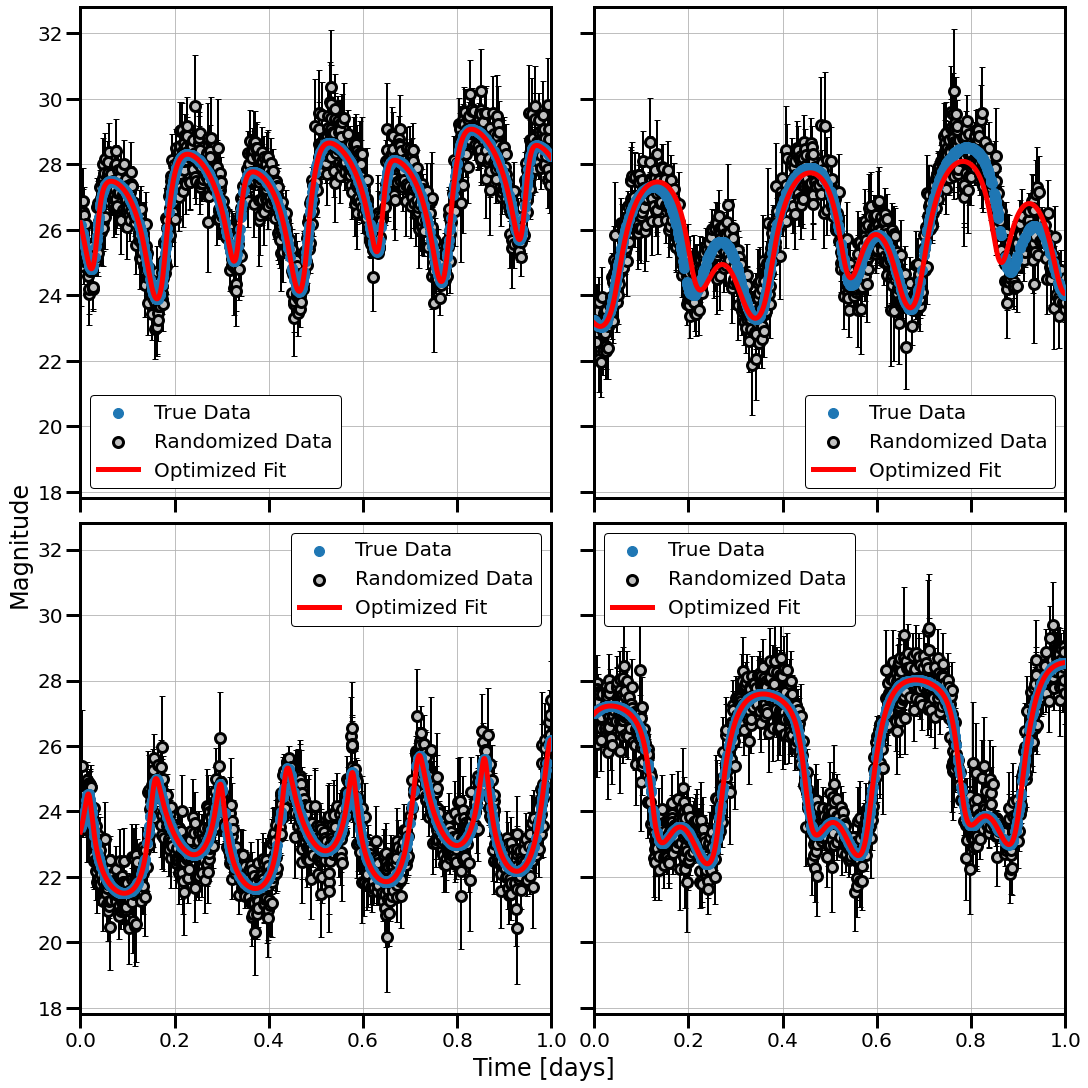

In [4]:
np.random.seed(523903133)

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(15,15),sharex=True,sharey=True,constrained_layout=True)
axes=axes.flatten()

for ax in axes:
    prand=np.random.uniform(6,8)/24
    thetarand=np.random.uniform(0,2*np.pi)
    phirand=np.random.uniform(0,np.pi)
    psirand=np.random.uniform(0,2*np.pi)
    betairand=np.random.uniform(0,2*np.pi)
    delVrand=np.random.uniform(30,35)
    tvals=[prand*24,thetarand, phirand,psirand,betairand,delVrand]
    print("True Values:", *[f'{x:.4f}' for x in tvals])

    xsamp=np.random.uniform(0,1,1000)
    xsamp=np.sort(xsamp)

    betarand=2*np.pi*(xsamp%prand)/prand
    alpharand=15*np.ones_like(betarand)
    alpharand=15+xsamp/3

    ysamp=delVrand-2.5*np.log10(evolving_axis_lightcurve(thetarand,phirand,psirand,115,111,19,alpharand,betarand-betairand))[0,:]

    ysampsig=np.random.normal(0,3*.1819,1000)*np.log10(np.sqrt(ysamp+100-np.min(ysamp)))

    rsig=0.25
    
    x0=[prand*24+np.random.normal(0,rsig),thetarand+np.random.normal(0,rsig),
        phirand+np.random.normal(0,rsig),psirand+np.random.normal(0,rsig),
        betairand+np.random.normal(0,rsig),delVrand+np.random.normal(0,rsig)]
    x0=np.maximum(x0,[6,0,0,0,0,20])
    x0=np.minimum(x0,[8,2*np.pi,np.pi/2,2*np.pi,2*np.pi,40])

    randopt,randcov = curve_fit(testHfunction,xsamp,ysamp+ysampsig,
                              p0=x0,sigma=ysampsig,absolute_sigma=True,
                              bounds=([6,0,0,0,0,20],[8,2*np.pi,np.pi,2*np.pi,2*np.pi,40]),maxfev=5000)

    print("Fit Values:",*[f'{x:.4f}' for x in randopt])
    print("Fit STD:",*[f'{x:.3f}' for x in np.abs(randopt-tvals)/np.sqrt(np.diag(randcov))])
    print("\n")
    
    ax.scatter(xsamp,ysamp,s=100,c='C0',zorder=3,label="True Data",rasterized=True)
    ax.errorbar(xsamp,ysamp+ysampsig,yerr=ysampsig,fmt='none',ecolor='k',elinewidth=2,capsize=3,rasterized=True)
    ax.scatter(xsamp,ysamp+ysampsig,s=100,edgecolors='k',linewidths=3,marker='o',color='silver',
               zorder=2,label="Randomized Data",rasterized=True)

    xplot=np.linspace(0,1,1000)
    curve=testHfunction(xplot,*randopt)
    ax.plot(xplot,curve,c='r',lw=5,zorder=4,label="Optimized Fit")
    ax.legend(fancybox=True,edgecolor='black',facecolor='white',framealpha=1)
    ax.grid()
    ax.set_xlim([0,1])
    
fig.supxlabel("Time [days]")
fig.supylabel("Magnitude")

#fig.set_rasterized(True)

plt.savefig("../Figures and Paper/validation_lightcurve.pdf",
           bbox_inches='tight',dpi=100)

print("Maximum Error:",np.max(testHfunction(xsamp,*randopt)-ysamp))

In [16]:
chilist=[]
opts=[]
for i in tqdm(range(10000)):
    prand=np.random.uniform(6,8)/24
    thetarand=np.random.uniform(0,2*np.pi)
    phirand=np.random.uniform(0,np.pi/2)
    psirand=np.random.uniform(0,2*np.pi)
    betairand=np.random.uniform(0,2*np.pi)
    delVrand=np.random.uniform(30,35)

    xsamp=np.random.uniform(0,1,1000)
    xsamp=np.sort(xsamp)

    betarand=2*np.pi*(xsamp%prand)/prand
    alpharand=15*np.ones_like(betarand)
    alpharand=15+xsamp/3

    ysamp=delVrand-2.5*np.log10(evolving_axis_lightcurve(thetarand,phirand,psirand,115,111,19,alpharand,betarand-betairand))[0,:]

    ysampsig=np.random.normal(0,3*.1819,1000)

    rsig=0.25
    
    x0=[prand*24+np.random.normal(0,rsig),thetarand+np.random.normal(0,rsig),
        phirand+np.random.normal(0,rsig),psirand+np.random.normal(0,rsig),
        betairand+np.random.normal(0,rsig),delVrand+np.random.normal(0,rsig)]
    x0=np.maximum(x0,[6,0,0,0,0,20])
    x0=np.minimum(x0,[8,2*np.pi,np.pi/2,2*np.pi,2*np.pi,40])
    try:
        randopt,randcov = curve_fit(testHfunction,xsamp,ysamp+ysampsig,
                                  p0=x0,sigma=ysampsig,absolute_sigma=True,
                                  bounds=([6,0,0,0,0,20],[8,2*np.pi,np.pi/2,2*np.pi,2*np.pi,40]),maxfev=5000)

        chilist.append(chi2(testHfunction(xsamp,*randopt),ysamp,np.ones_like(ysamp)))
        opts.append(randopt)
    except: print("Skipped")

  0%|          | 0/10000 [00:00<?, ?it/s]

Skipped
Skipped


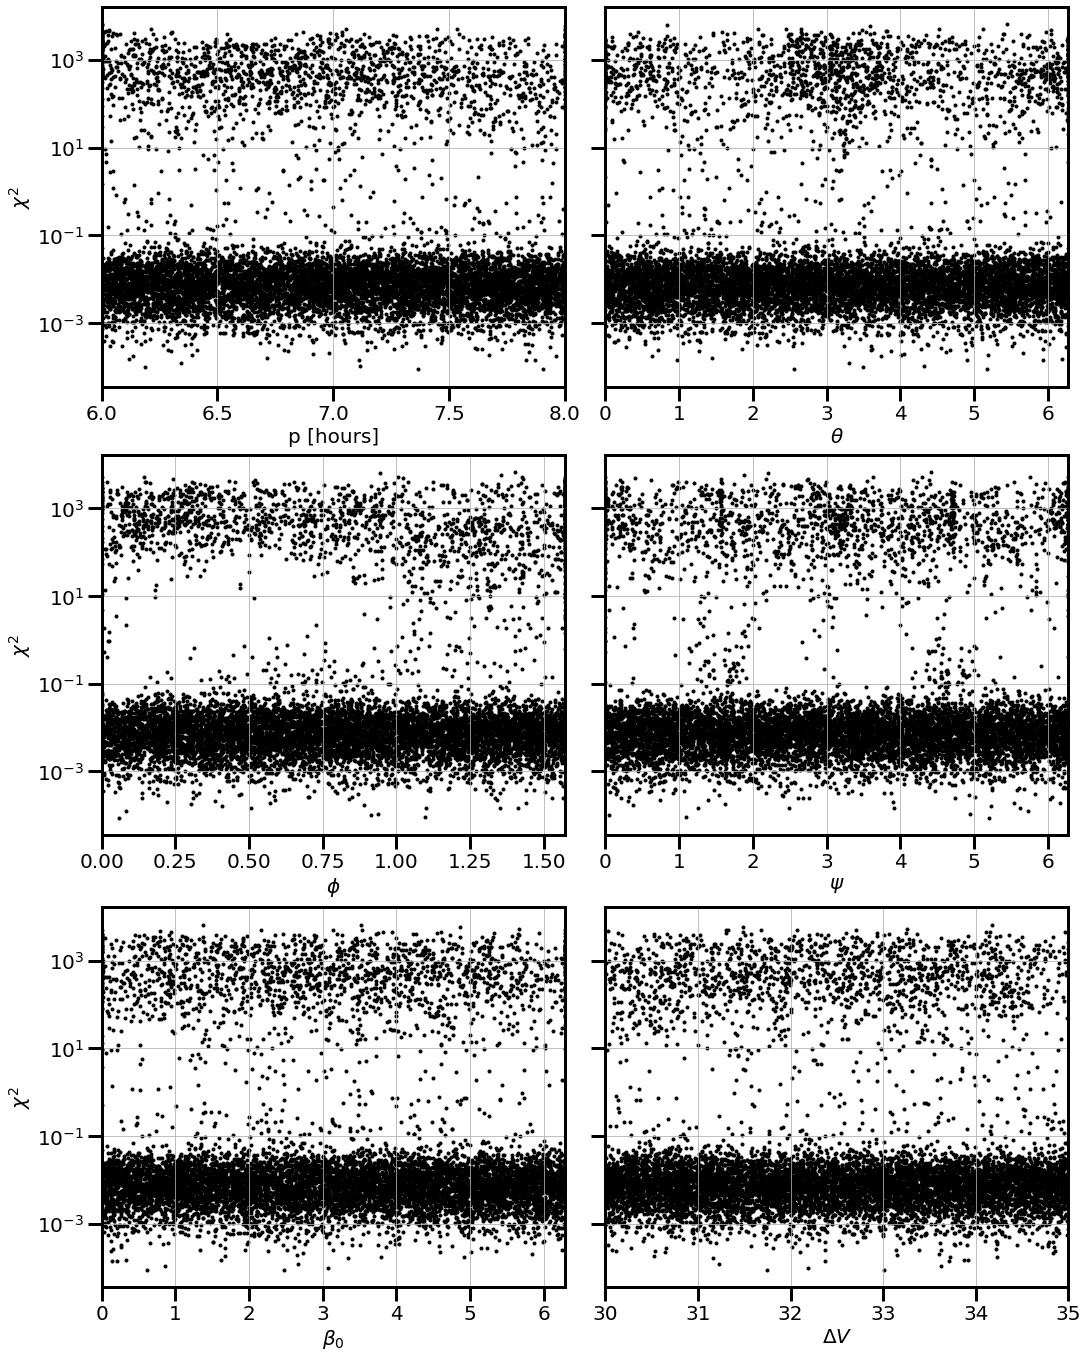

In [17]:
figx=15
figy=figx*figaspectratio

fig,axes=plt.subplots(3,2,figsize=(figx,figy),constrained_layout=True,sharey=True)

axes=axes.flatten()
opts=np.array(opts) 

labels=["p [hours]", r"$\theta$", r"$\phi$", r"$\psi$", r"$\beta_0$", r"$\Delta V$"]

for i in range(6):
    axes[i].scatter(opts[:,i],chilist,color='k',marker='.',rasterized=True)
    axes[i].set_xlabel(labels[i])
    if i%2==0:
        axes[i].set_ylabel(r"$\chi^2$")
    axes[i].set_yscale('log')
    axes[i].grid()
    
axes[0].set_xlim([6,8])
axes[1].set_xlim([0,2*np.pi])
axes[2].set_xlim([0,np.pi/2])
axes[3].set_xlim([0,2*np.pi])
axes[4].set_xlim([0,2*np.pi])
axes[5].set_xlim([30,35])
    
plt.savefig("../Figures and Paper/validation_chi2.pdf",
           bbox_inches='tight',dpi=150)